### 在資料集上測試 (MVtech)
資料集: 
> THE MVTEC ANOMALY DETECTION DATASET (MVTEC AD)
> https://www.mvtec.com/company/research/datasets/mvtec-ad


<img src="https://www.mvtec.com/fileadmin/Redaktion/mvtec.com/company/research/datasets/dataset_overview_large.png" alt="drawing" width="400"/>

In [1]:
!pip install -q --user albumentations

In [2]:
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import torch.optim as optim
from utils import show_image_mask, mask_CutMix
from unet import UNet

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' # for debug建議使用cpu作為torch的運行背景
device

device(type='cuda')

In [5]:
BATCH_SIZE = 16
NUM_LABELS = 1
WIDTH = 128
HEIGHT = 128

In [6]:
unet = UNet(num_class=1, padding = 'same', out_sz=(WIDTH,HEIGHT), retain_dim=False)
unet#.to(device)
x    = torch.randn(1, 3, WIDTH, HEIGHT)#.to(device)
y_pred = unet(x)
y_pred.shape

del unet

In [7]:
# import os   
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

In [8]:
item = 'capsule'
path = os.getcwd()
img_dir = f'{path}/data/{item}/test/scratch/'
print(len(os.listdir(img_dir)))
anno_dir = f'{path}/data/{item}/ground_truth/scratch/'

defective_number = [i.split('.')[0] for i in os.listdir(img_dir)]

23


### 取得image list
輸出: data_dic (字典)
- key: X_train, X_test, y_train, y_test

In [9]:
from sklearn.model_selection import train_test_split
mask_dir = lambda anno_dir, X_lis:[anno_dir+i.split('.')[0]+'_mask.png' for i in X_lis]

imgs_path_list = sorted(os.listdir(img_dir))

size = 1/len(imgs_path_list)
size = 0.1
train, test = train_test_split(imgs_path_list, train_size = size)

key = 'X_train, X_test, y_train, y_test'.split(', ')

lis = []
for number in [train, test]:
    lis.append([img_dir+i for i in number]) # X
for number in [train, test]:
    lis.append(mask_dir(anno_dir, number)) # y
data_dic = dict(zip(key, lis))
data_dic['X_train']

['/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/016.png',
 '/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/000.png']

### Build torch dataset

In [22]:
#  https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomImageDataset(Dataset):
    def __init__(self, imgs_path_list, anno_path_list, transform=None, target_transform=None):
        self.imgs_path_list = imgs_path_list
        self.anno_path_list = anno_path_list
        if type(imgs_path_list) != list:
            raise ValueError('Need Input a list')
        if type(anno_path_list) != list:
            raise anno_path_list('Need Input a list')
        self.transform = transform
#   
    def __len__(self):
        return len(self.imgs_path_list)
#         return 32

    def __getitem__(self, idx):
        img_path = self.imgs_path_list[idx]
        file_name = img_path.split('/')[-1].split('.')[0]
        mask_path = [i for i in self.anno_path_list if i.__contains__(file_name)][0]
        
        # cv2
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#       
        # cv2
        mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            transformed = transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        image = torch.Tensor(image)
#         image = image.unsqueeze(0)
        image = image.permute(2,0,1)
        
        mask = torch.Tensor(mask)
        mask = mask.unsqueeze(0)
        mask = mask.float()/255.


            
        return image, mask
    

#### 補充: 如何從dataset抽image, mask出來

torch.Size([3, 1000, 1000])
torch.Size([1, 1000, 1000])
(1000, 1000, 3)
(1000, 1000)


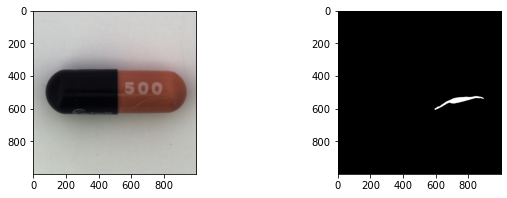

torch.Size([3, 1000, 1000])
torch.Size([1, 1000, 1000])
(1000, 1000, 3)
(1000, 1000)


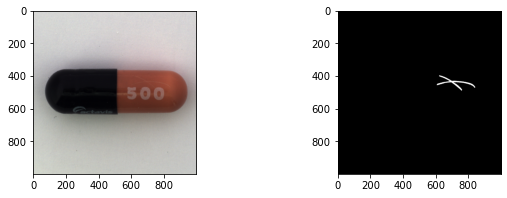

torch.Size([3, 1000, 1000])
torch.Size([1, 1000, 1000])
(1000, 1000, 3)
(1000, 1000)


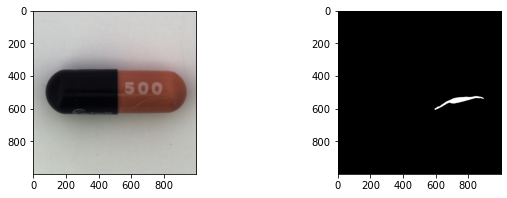

torch.Size([3, 1000, 1000])
torch.Size([1, 1000, 1000])
(1000, 1000, 3)
(1000, 1000)


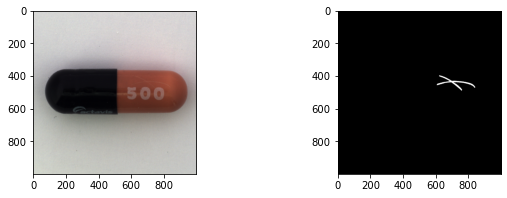

In [23]:
a = CustomImageDataset(data_dic['X_train'], data_dic['y_train'])
for idx in range(a.__len__()):
#     print(idx)

    test_image = a.__getitem__(idx)[0]
    test_mask = a.__getitem__(idx)[1]
    print(test_image.shape)
    print(test_mask.shape)
    
    test_image = test_image.squeeze(0).permute(1,2,0).int().numpy()
    test_mask = test_mask.squeeze(0).numpy().astype(np.uint8)
    print(test_image.shape)
    print(test_mask.shape)
    show_image_mask(test_image, test_mask)

#### 補充: 取得指定影像的瑕疵位置(x_min, y_min, x_max, y_max)

(1000, 1000)
[702.05221932 441.60835509]
4 POINTS , WIDTH + pad [588 328 816 556] 228


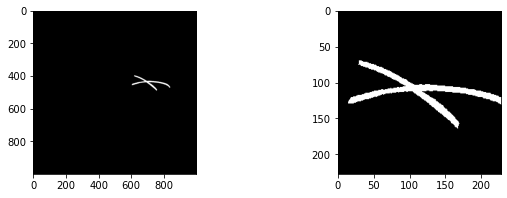

In [24]:
'''
可以針對某一張影像計算mask中包含瑕疵的位置在哪裡，用來對該影像作croping(裁切)，實現放大(rescale)的效果，幫助模型學習該影像對應的特徵。
'''
from utils import find_objects_contours, center_to_4point
arr = find_objects_contours(test_mask)
print(arr)
points = center_to_4point(test_mask, arr, WIDTH, pad=50)
print('4 POINTS , WIDTH + pad', points, points[2]-points[0])
x_min, y_min, x_max, y_max = points

show_image_mask(test_mask, test_mask[y_min:y_max, x_min:x_max])


'''
根據上面獲得的x_min, y_min, x_max, y_max 座標，對一些訓練資料做裁切，並將裁切到的區塊存進list，並在之後用來傳入mask_CutMix參數。
'''
print('')
# file = data_dic['X_train']
# file = np.random.choice(file,size=len(file), replace=False)
# file = [i.split('/')[-1].split('.')[0] for i in file]
# print(file)
# img_mask_list = []
# for i in file[:]:
#     print(i)
#     image = cv2.imread(f'/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/{i}.png')
#     print(image.shape)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     mask = cv2.imread(f'/home/jovyan/git/Image_Segmentation/PART2/data/capsule/ground_truth/scratch/{i}_mask.png', cv2.IMREAD_GRAYSCALE)
# #     show_image_mask(image, mask)
    
#     img_mask_list.append((image, mask))
# len(img_mask_list)


In [25]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/
from utils import mask_CutMix
transform = A.Compose([
#     mask_CutMix(img_mask_list, p=0.5),
#     A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, p=0.5),
    
    A.CenterCrop(300, 900, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
    A.Rotate((-30, 30), interpolation=0),  

    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

# target_transform = A.Compose([
#     A.ToFloat(always_apply=True),
#     A.Resize(WIDTH, HEIGHT),
# ])

In [26]:
# 建議同時間只有16個(128,128)的sample進行計算 (Total = BATCH_SIZE*MULTIPLE_BATCH)
BATCH_SIZE = 4
MULTIPLE_BATCH = 1 # [MULTIPLE_BATCH>1]

# 在這邊會強制對所有不滿BATCH_SIZE的訓練資料做數量上的匹配，接著透過CustomImageDataset的transform做資料擴增
if len(data_dic['X_train']) < 16: 
    lis = data_dic['X_train']
    lis = [lis[i%len(lis)] for i in range(BATCH_SIZE)]
    data_dic['X_train'] = lis
print(data_dic['X_train'])
dataset_train = CustomImageDataset(data_dic['X_train'], data_dic['y_train'], transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                                               pin_memory=True
                                              )
# dataloader_train = iter(dataloader_train)

# dataset_test = CustomImageDataset(data_dic['X_test'], data_dic['y_test'], transform=transform)
# dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, pin_memory=True)

['/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/016.png', '/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/000.png', '/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/016.png', '/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/000.png']


torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


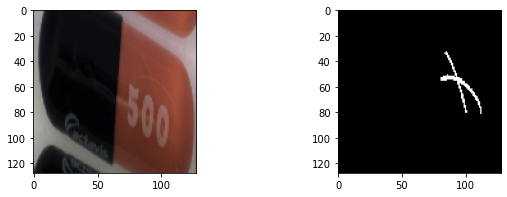

粗略估計正負樣本比例 tensor(inf) 負樣本/正樣本 tensor(1.) tensor(0.)
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


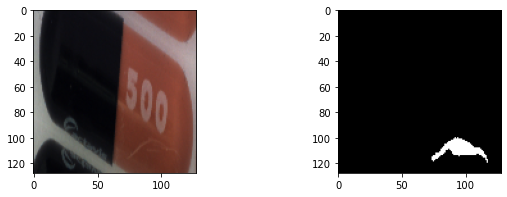

粗略估計正負樣本比例 tensor(0.) 負樣本/正樣本 tensor(0.) tensor(1.)
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


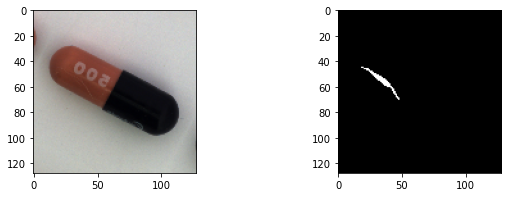

粗略估計正負樣本比例 tensor(inf) 負樣本/正樣本 tensor(1.) tensor(0.)
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


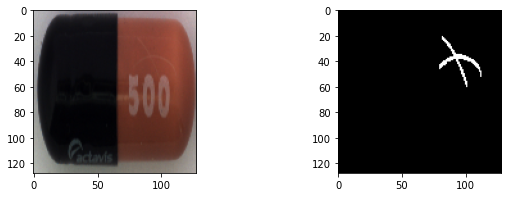

粗略估計正負樣本比例 tensor(inf) 負樣本/正樣本 tensor(1.) tensor(0.)


In [27]:
'''test transform on dataloader_train'''
for data in dataloader_train:
#     print(data.shape)
#     i = 0
    for x, y in zip(*data):
#         print(i)
#         i += 1
        print(x.shape)
        print(y.shape)
#         print(x)
#         print(x.squeeze(0).permute(1,2,0).int().numpy())
        show_image_mask(x.squeeze(0).permute(1,2,0).numpy(), y.squeeze(0).int())
#         print(sum(y)/())
        a = y.sum()//255
        print('粗略估計正負樣本比例', (len(y)**2-a)/a, '負樣本/正樣本', (len(y)**2-a), a)

In [28]:
model = UNet(num_class=NUM_LABELS, out_sz=(WIDTH,HEIGHT))
model.to(device) 
'''
要在建立optimizer之前就把model的參數移到gpu裡面 
ref: https://pytorch.org/docs/stable/optim.html 
'''

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([100]).to(device))
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [29]:
# model = torch.load('save.pt')

In [30]:
class patience():
    def __init__(self, patience=None):
        self.patience = patience
        self.record_value = 0
        self.early_stop = False
        self.ini = True
    def record(self):
        if self.patience != -1:
            if self.ini and not self.patience:
                print('No early stop')
                self.ini = False
                self.patience = -1
            else:
                if self.record_value >= self.patience:
                    print('early stop')
                    self.early_stop = True
                self.record_value += 1
    def reset(self):
        self.record_value = 0

In [31]:
best_loss = None
# VALUE = None
monitor = patience(None)
    
for epoch in range(500):  # loop over the dataset multiple times
    torch.cuda.empty_cache()
    running_loss = 0.0
#     sample_i = 0
    
    if monitor.early_stop:
        break
    
    multiple_inputs = torch.Tensor([])
    multiple_mask = torch.Tensor([])
    
    for multiple_batch in range(MULTIPLE_BATCH):
        for i, data in enumerate(dataloader_train, 1): # get each batch, setting drop_last
#             print(i, len(data))
            inputs, mask = data
#             print(inputs.shape)
#             print(mask.shape)
#             print(len(inputs))
            multiple_inputs = torch.cat((multiple_inputs, inputs),
                                        dim=0)
            multiple_mask = torch.cat((multiple_mask, mask),
                                        dim=0)
    inputs = multiple_inputs.to(device)
    mask = multiple_mask.to(device)

#     print(inputs.shape)
#     inputs = inputs.permute(0,3,1,2)
#     mask = mask.unsqueeze(1)
#     mask = mask.float()/255
#     print(inputs.shape)
    # zero the parameter gradients
    for param in model.parameters():
        param.grad = None
#     optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, mask)
    loss.backward()
    optimizer.step()
    
    # print statistics
    running_loss += loss.item()

    running_loss = running_loss/len(multiple_inputs)
    print(f'epochs: {epoch}, average sample loss: {running_loss:.8f}')
    
    monitor.record()
    
#     if monitor.record() and running_loss >= best_loss:

#     print(best_loss, running_loss)
    if not best_loss:
        best_loss = running_loss
#     elif epoch % 100 == 1:
#         torch.save(model, f'{epoch}_save.pt')
    elif running_loss < 0.9*best_loss:
        best_loss = running_loss
        torch.save(model, 'best_save.pt')
        monitor.reset()
        print('save torch model [best_save.pt]')
    

    

    running_loss = 0.0

torch.save(model, 'last_save.pt')
        
# print('Finished Training')

torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 3, 128, 128])
epochs: 0, average sample loss: 0.47424224
No early stop
torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 3, 128, 128])
epochs: 1, average sample loss: 0.28973415
save torch model [best_save.pt]
torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 3, 128, 128])
epochs: 2, average sample loss: 0.24493971
save torch model [best_save.pt]
torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 3, 128, 128])
epochs: 3, average sample loss: 0.20855528
save torch model [best_save.pt]
torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 3, 128, 128])
epochs: 4, average sample loss: 0.21499188
torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 3, 128, 128])
epochs: 5, average sample loss: 0.20273404
torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 3, 128, 128])
epochs: 6, average samp

KeyboardInterrupt: 

In [ ]:
test_set = iter(dataloader_train)

In [ ]:
image, mask = test_set.next()
print(image.shape)
mask.max()

In [ ]:
image = image.permute(0,3,1,2).to(device)
mask = mask.unsqueeze(1).to(device)
mask = mask.float()
print(image.shape)
print(mask.shape)

outputs = model(image)
print(outputs.shape)
loss = criterion(outputs, mask)
print(loss)


a = image.permute(0,2,3,1).squeeze(0).cpu().numpy()
b = mask.permute(0,2,3,1).squeeze(0).squeeze(-1).cpu().numpy()
# print(a.shape)
# print(b.shape)
# for x,m in zip(a, b):
#     show_image_mask(x, m)
    

# outputs = model(image)
# print(outputs.shape)
c = outputs.permute(0,2,3,1).squeeze(0).squeeze(-1).cpu().detach().numpy()
# print(c.shape)
# b = mask.permute(0,2,3,1).squeeze(0).squeeze(-1).cpu().numpy()
# show_image_mask(a, b)
# print(a.shape)
# print(b.shape)
# show_image_mask(a,b,c)
for x, m, p in zip(a, b, c):
    show_image_mask(x, m, p)